In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [47]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def plot_spatio_temporal(sta,dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=26, width=26, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [8]:
data_path = 'data'
dataset = '20201209'

info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))
data = np.load(os.path.join(data_path, dataset + '.npz'))

stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

85

## calc STA for an RGC

In [4]:
print(stim.shape)
print(spike_counts.shape)

(27000, 676)
(85, 27000)


In [80]:
# choose a channel
# ch_idx = 22   # 33c	ON
# ch_idx = 29   # 37b ON
# ch_idx = 41     # 48b OFF
ch_idx = 67     # 71c ON


# small p2p
# ch_idx = 81  #85b ON-OFF
#ch_idx = 84 #87b ON

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

71c ON


(25600, 676, 12)
peak diff. = 0.11


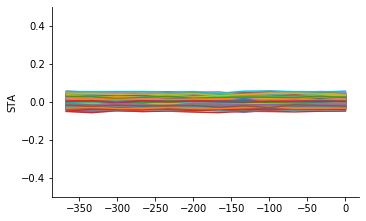

<Figure size 432x288 with 0 Axes>

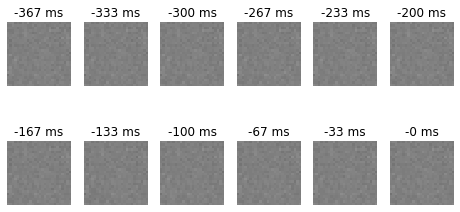

In [83]:
tap=12
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)


import os
if not os.path.exists(os.path.join('figure', 'sta')):
    os.makedirs(os.path.join('figure', 'sta'))
    
plot_spatio_temporal(sta, ylabel='STA',
                     fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

## calc STA and peak-to-peak difference for all RGCs

In [84]:
# choose a channel
sta_p2ps = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps

info.to_csv(dataset + '_sta.csv', index=None)

13a ON
13b ON
14a ON-OFF
16a Unknown
17a ON-OFF
21a ON-OFF
22a ON-OFF
22b Unknown
23a Unknown
23b ON-OFF
24a Unknown
24b ON-OFF
25a Unknown
25b ON-OFF
26a ON-OFF
26b ON-OFF
28a ON-OFF
28b Unknown
28c ON
32a ON-OFF
33a ON
33b ON-OFF
33c ON
34a OFF
34b ON-OFF
35a ON
36a ON-OFF
36b ON
37a ON-OFF
37b ON
38a ON-OFF
41a ON-OFF
42a ON
42b ON
43a ON-OFF
45a Unknown
45b ON
46a ON-OFF
47a ON-OFF
47b ON
48a ON
48b OFF
51a ON-OFF
51b Unknown
51c Unknown
52a ON-OFF
52b ON-OFF
54a OFF
54b Unknown
54c Unknown
55a Unknown
55b OFF
56a ON-OFF
57a ON-OFF
58a ON
58b ON
61a ON
61b OFF
62a ON
63a ON
64a ON-OFF
65a ON
66a OFF
67a ON
68a ON
71a ON-OFF
71b ON
71c ON
73a ON
73b ON
74a ON-OFF
75a ON
77a OFF
77b ON
78a ON
78b ON-OFF
82a OFF
83a ON-OFF
84a OFF
84b ON-OFF
85a ON-OFF
85b ON-OFF
86a ON-OFF
87a Unknown
87b ON


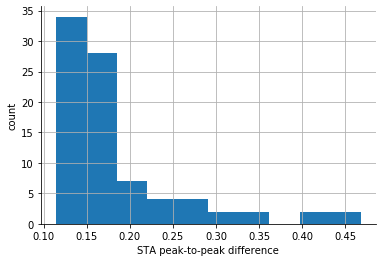

In [85]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

In [87]:
idx_high_snr = info['sta_p2p'] >= 0.4
info[idx_high_snr]

,channel,cell_type,sta_p2p
22,33c,ON,0.437594
29,37b,ON,0.467883
41,48b,OFF,0.415474
67,71c,ON,0.402123


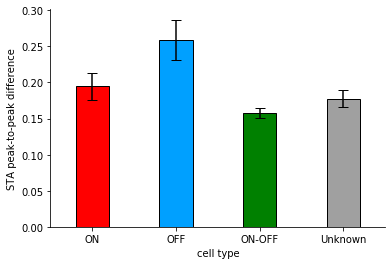

In [90]:
cell_types = ['ON', 'OFF', 'ON-OFF', 'Unknown']
means = info.groupby('cell_type')['sta_p2p'].mean()[cell_types]
sems = info.groupby('cell_type')['sta_p2p'].sem()[cell_types]


plt.bar(cell_types, means, yerr=sems,
        width=0.4, color=['r','#00A0FF','green', '#A0A0A0'], edgecolor='k', linewidth=1,
        capsize=5)
plt.ylabel('STA peak-to-peak difference')
plt.xlabel('cell type')

plt.xlim(-0.5, 3.5)
remove_box()

plt.savefig("figure/sta/peak_diff_bar.pdf", bbox_inches='tight')
plt.savefig("figure/sta/peak_diff_bar.png", bbox_inches='tight')

In [92]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.0697775601099512
0.11146898992571361
